In [2]:
file_id = '1uQSV1xGuJuDTdzItdFC7s5Lb4EzdbV_-'
output = 'datasetzip'
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


Downloading...
From: https://drive.google.com/uc?id=1uQSV1xGuJuDTdzItdFC7s5Lb4EzdbV_-
To: /kaggle/working/datasetzip
100%|██████████| 18.1M/18.1M [00:00<00:00, 101MB/s] 


In [3]:
image_size = (100, 100)
def load_images(paths, size=(100, 100)):
    images = []
    for path in paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        img = img / 255.0
        images.append(img)

    return np.array(images)

image_paths = glob("/content/dataset/A_23/*.jpg")
images = load_images(image_paths, size=image_size)
print("Shape:", images.shape)

Shape: (1074, 100, 100, 3)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,  Dropout, BatchNormalization, Flatten, Dense, Reshape, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
# !pip install gdown
import zipfile
import gdown
from glob import glob
from PIL import Image
import random
import cv2
!pip install keras-tuner
import keras_tuner as kt
SEED_VALUE = 123
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

2025-06-26 18:46:21.839941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750963581.862878    4775 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750963581.869702    4775 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## A. EDA

In [4]:
print(f"Image shape: {images.shape[1:]}")
print(f"Max pixel: {np.max(images)}, Min pixel: {np.min(images)}")

Image shape: (100, 100, 3)
Max pixel: 1.0, Min pixel: 0.0


Di tahap awal, saya melakukan load gambar-gambar dari folder dataset menggunakan OpenCV. Setiap gambar diubah dari format BGR ke RGB, lalu di-resize ke ukuran 100x100 agar seragam. Setelah itu, semua gambar dinormalisasi ke rentang nilai 0–1 supaya lebih cocok untuk model nantinya.

Hasilnya, saya mendapatkan array gambar dengan shape (1074, 100, 100, 3), yang artinya ada 1074 gambar RGB. Nilai pikselnya juga sudah terkonfirmasi berada di rentang 0.0 hingga 1.0, menandakan bahwa proses preprocessing sudah berjalan dengan baik.

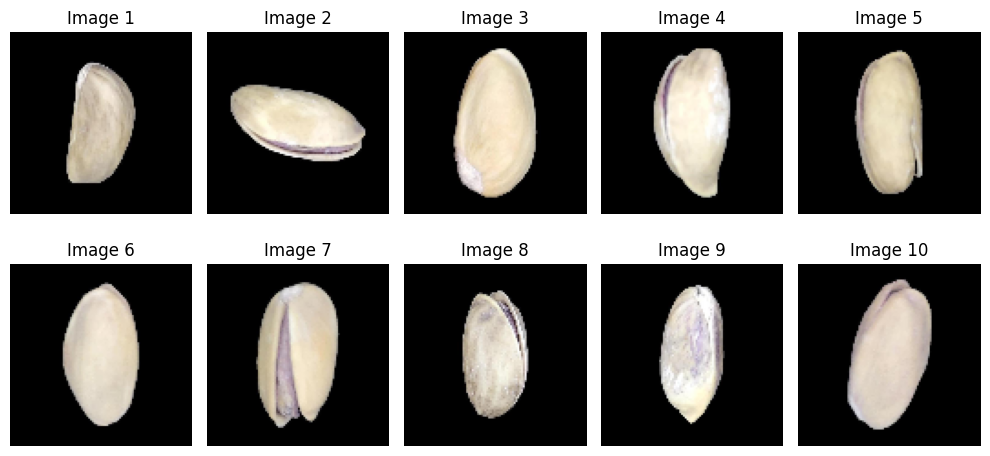

In [23]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Image {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Dari visualisasi awal ini, terlihat bahwa bentuk, posisi, dan orientasi objek cukup bervariasi di mana ada yang berada di tengah, agak miring, bahkan sebagian terpotong. Namun, background hitam yang konsisten membuat objek utama cukup menonjol, sehingga dapat membantu proses pembelajaran fitur oleh model autoencoder nantinya tanpa gangguan latar belakang yang kompleks.

Untuk melihat seberapa jelas batas objeknya, saya menggunakan edge detection dengan algoritma Canny. Hasil deteksinya memperlihatkan bahwa kontur pistachio cukup tajam dan bisa dibedakan dengan jelas dari backgroundnya. Ini jadi indikasi positif karena model autoencoder nanti kemungkinan bisa menangkap representasi bentuk dengan cukup baik.

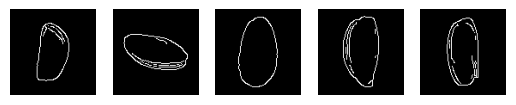

In [ ]:
for i in range(5):
    gray = cv2.cvtColor((images[i]*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    plt.subplot(1, 5, i+1)
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
# plt.suptitle("Edge Detection (Canny)")
plt.show()


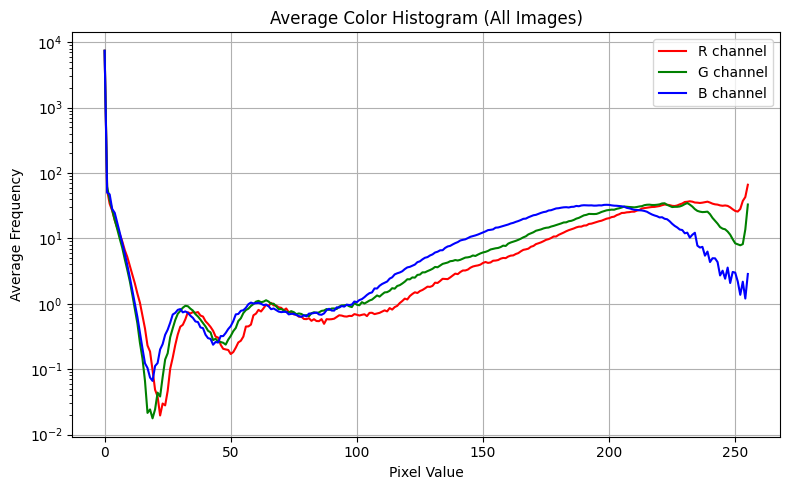

R Mean: 0.2000, Std: 0.3624
G Mean: 0.1890, Std: 0.3439
B Mean: 0.1739, Std: 0.3163


In [7]:
def plot_avg_color_hist(images):
    avg_hist = np.zeros((3, 256))
    for img in images:
        img_uint8 = (img * 255).astype('uint8')
        for i in range(3):  # channel R, G, B
            hist = cv2.calcHist([img_uint8], [i], None, [256], [0, 256])
            avg_hist[i] += hist[:, 0]

    avg_hist /= len(images)  # average

    plt.figure(figsize=(8, 5))
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        plt.plot(avg_hist[i], color=color, label=f"{color.upper()} channel")
    plt.title("Average Color Histogram (All Images)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Average Frequency")
    plt.legend()
    plt.grid()
    plt.yscale("log") 
    plt.tight_layout()
    plt.show()

plot_avg_color_hist(images)
means = images.mean(axis=(0, 1, 2))
stds = images.std(axis=(0, 1, 2))
for i, c in zip(range(3), ['R', 'G', 'B']):
    print(f"{c} Mean: {means[i]:.4f}, Std: {stds[i]:.4f}")

Selanjutnya, saya mengaecek distribusi warna/RGB pada dataset menggunakan color histogram. Dari grafik, terlihat bahwa mayoritas nilai pixel cenderung tinggi di rentang terang (sekitar 200 ke atas), yang masuk akal mengingat latar belakang gambar umumnya hitam pekat sementara objek pistachio sendiri memiliki warna yang cukup cerah (putih kekuningan).Channel biru memiliki frekuensi lebih tinggi di bagian gelap, sedangkan merah (R) terlihat sedikit lebih dominan di area terang.Mean dan standar deviasi dari tiap channel menunjukkan bahwa distribusi warnanya relatif stabil, meskipun channel R punya variasi yang sedikit lebih besar.

## B. Preprocessing (+Additional EDA)

In [24]:
x_train, x_temp = train_test_split(images, test_size=0.2, random_state=SEED_VALUE)
x_val, x_test = train_test_split(x_temp, test_size=0.5, random_state=SEED_VALUE)
print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

Train: (859, 100, 100, 3), Val: (107, 100, 100, 3), Test: (108, 100, 100, 3)


Kemudian, saya melakukan split dataset dengan rasio 80:10:10 sesuai ketentuan soal, yaitu untuk data training, validation, dan testing. Hasil akhirnya adalah 859 gambar untuk training, 107 untuk validation, dan 108 untuk testing.


In [25]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(loc=mean, scale=std, size=images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

x_train_noisy = add_gaussian_noise(x_train)
x_val_noisy = add_gaussian_noise(x_val)
x_test_noisy = add_gaussian_noise(x_test)


Sesuai instruksi soal, saya menambahkan noise pada gambar dengan menggunakan distribusi Gaussian dengan mean 0.0 dan standar deviasinya 0.1. Proses ini bertujuan untuk membuat versi ‘rusak’ dari gambar asli, yang nantinya akan digunakan sebagai input bagi model autoencoder.

Dari visualisasi hasilnya, bisa dilihat bahwa pistachio yang terkena noise tetap mempertahankan bentuk umumnya, meskipun muncul gangguan acak berupa titik titik berwarna di seluruh area. Ini ideal untuk tugas denoising, karena meski gambar jadi terlihat ‘kotor’, informasi bentuk utama tetap bisa dikenali.

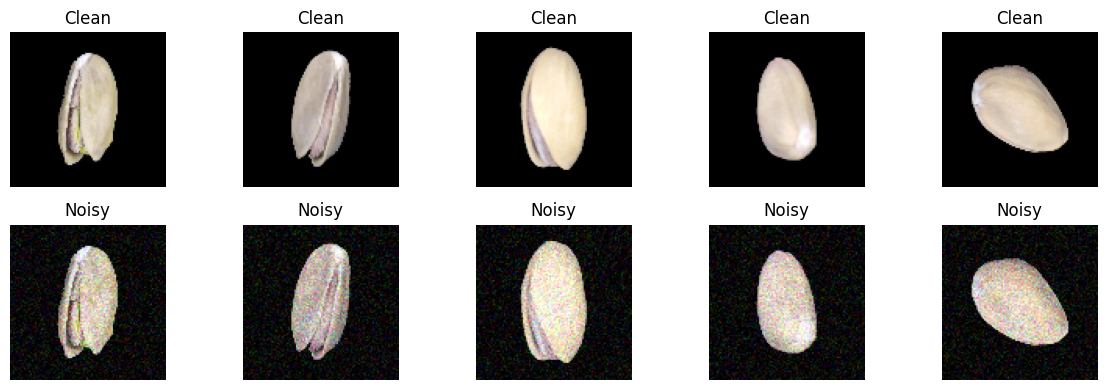

In [26]:
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title("Clean")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [27]:
def calculate_rgb_ssim_batch(originals, noisies):
    scores = []
    for i in range(len(originals)):
        ori = (originals[i] * 255).astype('uint8')
        noisy = (noisies[i] * 255).astype('uint8')
        score = ssim(ori, noisy, data_range=255, channel_axis=-1)
        scores.append(score)
    return np.mean(scores)


In [28]:
ssim_train = calculate_rgb_ssim_batch(x_train, x_train_noisy)
ssim_val = calculate_rgb_ssim_batch(x_val, x_val_noisy)
ssim_test = calculate_rgb_ssim_batch(x_test, x_test_noisy)

print(f"Avg SSIM Train (noisy vs clean): {ssim_train:.4f}")
print(f"Avg SSIM Val   (noisy vs clean): {ssim_val:.4f}")
print(f"Avg SSIM Test  (noisy vs clean): {ssim_test:.4f}")

Avg SSIM Train (noisy vs clean): 0.2212
Avg SSIM Val   (noisy vs clean): 0.2233
Avg SSIM Test  (noisy vs clean): 0.2260


Sebagai tambahan, saya juga menghitung nilai Structural Similarity Index (SSIM) antara gambar noisy dan gambar aslinya. Didapat bahwa nilai SSIM rata rata berada di kisaran 0.22 untuk data train, validation, dan test. Ini menandakan bahwa meskipun bentuk objek masih bisa dikenali, noise yang ditambahkan cukup signifikan dalam mengganggu struktur visual asli gambar. Nilai SSIM yang cukup rendah ini bisa dilihat sebagai tantangan karena model harus bisa membedakan antara noise dan fitur penting, tapi juga peluang karena jika model berhasil mempelajari representasi yang baik, peningkatan SSIM setelah denoising bisa jadi cukup signifikan.

## C. Baseline Model

In [29]:
input_img = Input(shape=(100, 100, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)        # (100, 100, 32)
x = MaxPooling2D((2, 2), padding='same')(x)                                 # (50, 50, 32)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)                # (50, 50, 64)
x = MaxPooling2D((2, 2), padding='same')(x)                                 # (25, 25, 64)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)                # (25, 25, 64)
x = UpSampling2D((2, 2))(x)                                                 # (50, 50, 64)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)                # (50, 50, 32)
x = UpSampling2D((2, 2))(x)                                                 # (100, 100, 32)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)        # (100, 100, 3)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 100, 100, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

Sesuai dengan ketentuan soal, saya membangun model autoencoder menggunakan kombinasi layer konvolusi, pooling, dan upsampling. Input dari model berukuran (100, 100, 3) dan akan direkonstruksi kembali ke ukuran yang sama setelah melalui proses encoding dan decoding. Proses encoding dilakukan melalui tiga buah Conv2D layer dengan ukuran kernel (3, 3) dan aktivasi ReLU, yang diselingi oleh MaxPooling2D untuk mengurangi dimensi spasial. Setelah mencapai representasi laten di ukuran (25, 25, 64), model kemudian melakukan decoding secara bertahap menggunakan UpSampling2D dan Conv2D, lalu diakhiri dengan layer output Conv2D berdimensi 3 channel dan aktivasi sigmoid.

In [30]:
history1 = autoencoder.fit(x_train_noisy, x_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val_noisy, x_val)
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.1228 - val_loss: 0.0142
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0120 - val_loss: 0.0068
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

## D Modifikasi Model

In [41]:
input_img = Input(shape=(100, 100, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)       # (100, 100, 64)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)                                # (50, 50, 64)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)              # (50, 50, 128)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)                                # (25, 25, 128)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)              # (25, 25, 256)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)              # (25, 25, 128)
x = UpSampling2D((2, 2))(x)                                                # (50, 50, 128)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)               # (50, 50, 64)
x = UpSampling2D((2, 2))(x)                                                # (100, 100, 64)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)       # (100, 100, 3)

Untuk eksperimen kedua, saya mencoba memodifikasi arsitektur autoencoder agar lebih dalam. Perubahan utama ada di jumlah filter dan penambahan BatchNormalization setelah setiap convolution layer. Encoder dimulai dengan 64 filter, lalu naik jadi 128 dan 256, yang bertujuan untuk menangkap fitur yang lebih kompleks dari gambar. Setelah itu, decoder menurunkan kembali jumlah channel secara bertahap sambil mengembalikan dimensi spasial melalui UpSampling.

In [32]:
autoencoder2 = Model(input_img, decoded)
autoencoder2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 50, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 25, 25, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 50, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 100, 100, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 742,147 (2.83 MB)

 Trainable params: 741,763 (2.83 MB)

 Non-trainable params: 384 (1.50 KB)

In [33]:
history2 = autoencoder2.fit(
    x_train_noisy, x_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val_noisy, x_val)
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 0.0783 - val_loss: 0.0831
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0521 - val_loss: 0.0485
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0517 - val_loss: 0.0572
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0517 - val_loss: 0.0694
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0530 - val_loss: 0.0586
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0519 - val_loss: 0.0652
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0519 - val_loss: 0.0726
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0512 - val_loss: 0.0679
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0507 - val_loss: 0.1200
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0514 - val_loss: 0.1101
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0502 - val_loss: 0.1104
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/st

## E. Evaluasi

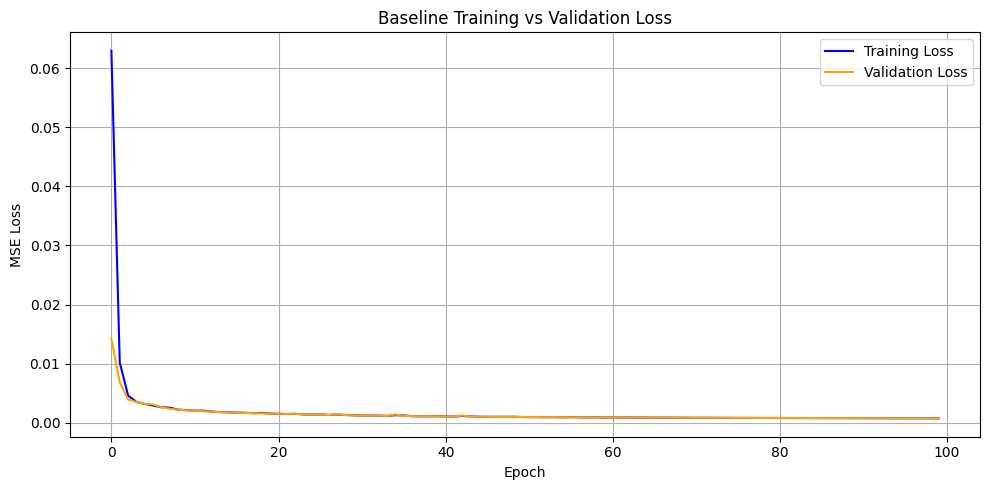

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(history1.history['loss'], label='Training Loss', color='blue')
plt.plot(history1.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Baseline Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Dari plot loss untuk model baseline, terlihat bahwa model autoencoder berhasil belajar dengan cukup stabil. Kedua kurva loss baik training maupun validation, menunjukkan penurunan drastis di awal epoch dan kemudian melandai seiring waktu. Hal ini mengindikasikan bahwa model mampu mempelajari representasi data dengan baik tanpa overfitting.

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


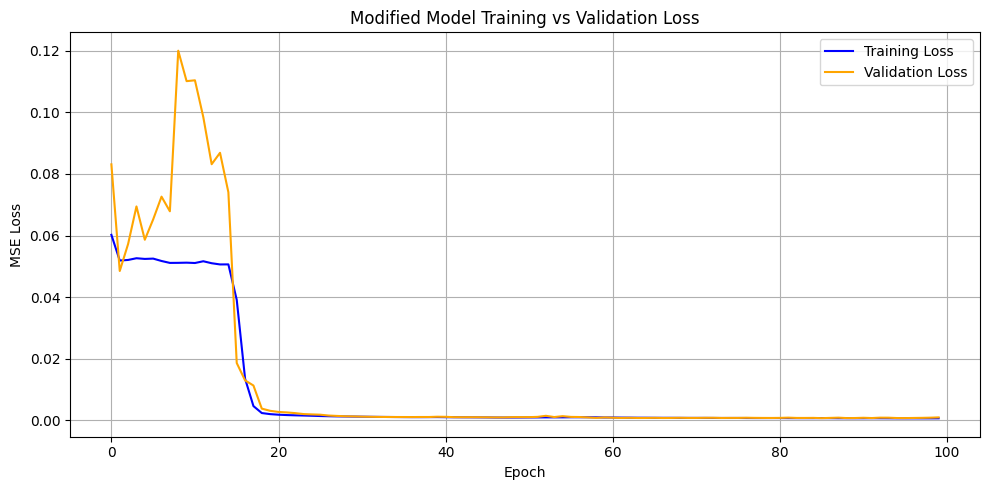

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'], label='Training Loss', color='blue')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Modified Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Sementara itu, pada model yang telah dimodifikasi, terlihat adanya fluktuasi cukup tajam pada kurva validation loss di awal training, yang kemudian turun drastis dan menyatu dengan training loss setelah sekitar 20 epoch. Meskipun awalnya sempat overfitting, model berhasil mengejar dan akhirnya mencapai performa yang setara. Ini bisa jadi indikasi bahwa model ini butuh waktu lebih untuk stabil karena adanya perubahan arsitektur, tetapi pada akhirnya bisa belajar dengan efektif.

In [34]:
x_test_pred = autoencoder.predict(x_test_noisy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


In [35]:
x_test_pred2 = autoencoder2.predict(x_test_noisy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


In [36]:
def calculate_ssim(originals, predictions):
    scores = []
    for i in range(len(originals)):
        ori = (originals[i] * 255).astype('uint8')
        pred = (predictions[i] * 255).astype('uint8')
        
        score = ssim(ori,pred,data_range=255,channel_axis=-1)
        scores.append(score)
    return np.mean(scores)


In [37]:
ssim_rgb1 = calculate_ssim(x_test, x_test_pred)
print(f"SSIM Model 1: {ssim_rgb1:.4f}")

SSIM Model 1: 0.9530


In [38]:
ssim_rgb2 = calculate_ssim(x_test, x_test_pred2)
print(f"SSIM Model 2: {ssim_rgb2:.4f}")

SSIM Model 2: 0.9575


Nilai SSIM dari kedua model menunjukkan performa yang sangat baik dalam merekonstruksi gambar. Model pertama menghasilkan skor SSIM sebesar 0.9530, sementara model kedua sedikit lebih tinggi di angka 0.9575. Secara umum, nilai di atas 0.9 menunjukkan bahwa hasil rekonstruksi memiliki kemiripan visual yang tinggi dengan gambar aslinya, terutama dalam hal struktur dan detail. Ini menandakan bahwa model sudah cukup mampu memahami fitur-fitur penting pada gambar pistachio.

Kenaikan SSIM pada model kedua meskipun tidak besar, tetap menunjukkan adanya peningkatan kualitas rekonstruksi. Hal ini sejalan dengan pengamatan sebelumnya pada plot loss, di mana model kedua membutuhkan waktu lebih lama untuk stabil namun akhirnya menyamai performa baseline. Dengan SSIM mendekati 1, saya cukup yakin bahwa autoencoder yang dibuat sudah bekerja dengan optimal untuk tugas denoising pada dataset ini.